In [161]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd 
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def classify(model, tokenizer, texts, device="cuda:1"):
    # Set the model to evaluate mode
    model.eval()

    # Tokenize the input sentences and create input tensors for the model
    inputs = tokenizer(
            texts,
            truncation=True,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            return_tensors="pt")

    # Pass the inputs through the model to get the predicted labels
    labels = []
    with torch.no_grad():
        outputs = model(inputs['input_ids'].to(device), attention_mask=inputs['attention_mask'].to(device))
        logits = outputs.logits.detach().cpu().numpy()
        # If the first logit is greater than 3, append 1 (True) to the labels list, else append 0 (False)
        labels.append([1 if logit[0] > 5 else 0 for logit in logits])

    return labels

def datapoints(df, model, tokenizer):
    labels = []
    for i, row in df.iterrows():
        try:
            labels.append(classify(model,tokenizer,row["text"]))
        except:
            print("Didn't work")
    return labels
    
 
    
    


In [170]:
model = "/scratch/venia/socialgpt/venia_worker_vs_gpt/models/gpturk_transductive_size:766_intfloat/e5-base/checkpoint-384"



In [171]:
device = "cuda:1"
df = pd.read_csv("../data/processed_responses.csv")



In [172]:
df = df[df["summary"].map(len) > 20]

In [173]:
df = df.rename({"summary":"text"}, axis=1)

In [174]:
# df = pd.read_csv("/scratch/venia/socialgpt/SocialSynth/data/sarcasm/synth/Train-SynthReal.csv").sample(10)
model = AutoModelForSequenceClassification.from_pretrained(model).to(device)
tokenizer = AutoTokenizer.from_pretrained("intfloat/e5-base")
labels = datapoints(df, model, tokenizer)


In [175]:
mapping = {1: "synthetic", 0: "real"}

In [176]:
df["predicted"] = [mapping[k[0][0]] for k in labels]

In [177]:
df.groupby("predicted")["HITId"].count()

predicted
real         31
synthetic    16
Name: HITId, dtype: int64

In [178]:
df.to_csv("../data/processed_responses_with_predictions2.csv", index=False)

,HITId,original_text,key_strokes,datetime,text,copied,predicted
0,309D674SHZ6NLN8CVPB7DNTRX7EBCC,Comparison of Weight-Loss Diets with Different...,Backspace Backspace Backspace Backspace Backsp...,"['2023-06-01T07:06:03.732Z', '2023-06-01T07:06...",We randomly assigned 811 overweight adults to ...,True,real
1,309D674SHZ6NLN8CVPB7DNTRX7EBCC,Comparison of Weight-Loss Diets with Different...,copy paste copy paste,"[None, None, None, None]","onths, participants assigned to each diet had ...",True,real
2,309D674SHZ6NLN8CVPB7DNTRX7EBCC,Comparison of Weight-Loss Diets with Different...,copy paste,"[None, None]",In this two-year study of 811 overweight adult...,True,synthetic
3,3XABXM4AJ1Q8DQKOXVSS6QS7TGU8QF,Effect of Screening Mammography on Breast-Canc...,Shift Shift Shift Shift Shift Shift Shift Shif...,"['2023-06-01T10:42:22.995Z', '2023-06-01T10:42...",The Norwegian breast-cancer screening program ...,False,real
4,3XABXM4AJ1Q8DQKOXVSS6QS7TGU8QF,Effect of Screening Mammography on Breast-Canc...,copy Control V paste,"[None, '2023-06-01T06:39:50.070Z', '2023-06-01...",This study examined the effect of screening ma...,True,synthetic
5,3XABXM4AJ1Q8DQKOXVSS6QS7TGU8QF,Effect of Screening Mammography on Breast-Canc...,copy paste Control v paste,"[None, None, '2023-06-01T06:40:06.904Z', '2023...",The effect of screening mammography on breast ...,True,synthetic
6,3BFF0DJK8XX3OQRPSXSSSM3VPHZTSD,"First Results of Phase 3 Trial of RTS,S/AS01 M...",copy copy CapsLock Shift Control V paste,"[None, None, '2023-06-01T16:28:11.659Z', '2023...",Vaccine efficacy against severe malaria in th...,True,synthetic
7,3BFF0DJK8XX3OQRPSXSSSM3VPHZTSD,"First Results of Phase 3 Trial of RTS,S/AS01 M...",copy Control v paste,"[None, '2023-06-01T06:44:19.371Z', '2023-06-01...",The first results of a phase 3 trial for the R...,True,synthetic
8,3BFF0DJK8XX3OQRPSXSSSM3VPHZTSD,"First Results of Phase 3 Trial of RTS,S/AS01 M...",copy paste,"[None, None]",\nIn the 14 months after the first dose of vac...,True,real
9,3CESM1J3EIOQT9XMGPU0E1E2BMKW6K,Azithromycin and the Risk of Cardiovascular De...,copy Control V paste,"[None, '2023-06-01T06:39:08.321Z', '2023-06-01...","In this study, a Tennessee Medicaid cohort was...",True,synthetic


In [140]:
df[df["copied"] == True]

,HITId,original_text,key_strokes,datetime,text,copied,predicted
0,309D674SHZ6NLN8CVPB7DNTRX7EBCC,Comparison of Weight-Loss Diets with Different...,Backspace Backspace Backspace Backspace Backsp...,"['2023-06-01T07:06:03.732Z', '2023-06-01T07:06...",We randomly assigned 811 overweight adults to ...,True,real
1,309D674SHZ6NLN8CVPB7DNTRX7EBCC,Comparison of Weight-Loss Diets with Different...,copy paste copy paste,"[None, None, None, None]","onths, participants assigned to each diet had ...",True,real
2,309D674SHZ6NLN8CVPB7DNTRX7EBCC,Comparison of Weight-Loss Diets with Different...,copy paste,"[None, None]",In this two-year study of 811 overweight adult...,True,real
4,3XABXM4AJ1Q8DQKOXVSS6QS7TGU8QF,Effect of Screening Mammography on Breast-Canc...,copy Control V paste,"[None, '2023-06-01T06:39:50.070Z', '2023-06-01...",This study examined the effect of screening ma...,True,synthetic
5,3XABXM4AJ1Q8DQKOXVSS6QS7TGU8QF,Effect of Screening Mammography on Breast-Canc...,copy paste Control v paste,"[None, None, '2023-06-01T06:40:06.904Z', '2023...",The effect of screening mammography on breast ...,True,synthetic
6,3BFF0DJK8XX3OQRPSXSSSM3VPHZTSD,"First Results of Phase 3 Trial of RTS,S/AS01 M...",copy copy CapsLock Shift Control V paste,"[None, None, '2023-06-01T16:28:11.659Z', '2023...",Vaccine efficacy against severe malaria in th...,True,synthetic
7,3BFF0DJK8XX3OQRPSXSSSM3VPHZTSD,"First Results of Phase 3 Trial of RTS,S/AS01 M...",copy Control v paste,"[None, '2023-06-01T06:44:19.371Z', '2023-06-01...",The first results of a phase 3 trial for the R...,True,synthetic
8,3BFF0DJK8XX3OQRPSXSSSM3VPHZTSD,"First Results of Phase 3 Trial of RTS,S/AS01 M...",copy paste,"[None, None]",\nIn the 14 months after the first dose of vac...,True,synthetic
9,3CESM1J3EIOQT9XMGPU0E1E2BMKW6K,Azithromycin and the Risk of Cardiovascular De...,copy Control V paste,"[None, '2023-06-01T06:39:08.321Z', '2023-06-01...","In this study, a Tennessee Medicaid cohort was...",True,synthetic
10,3CESM1J3EIOQT9XMGPU0E1E2BMKW6K,Azithromycin and the Risk of Cardiovascular De...,copy paste copy \ Backspace Backspace Control ...,"[None, None, None, '2023-06-01T12:07:33.534Z',...","During 5 days of therapy, patients taking azit...",True,real


## Plot predictions

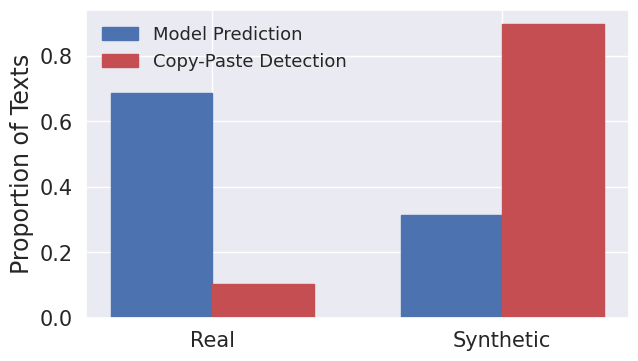

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the seaborn style is used
sns.set()

# Define the labels and proportions for each category
categories = ['Real', 'Synthetic']
model_prediction = [33/(13+35), 15/(13+35)]
copy_paste_detection = [5/(43+5), 43/(43+5)]

# Plotting
barWidth = 0.35
r1 = np.arange(len(categories)) # positions for first group of bars
r2 = [x + barWidth for x in r1] # positions for second group of bars

plt.figure(figsize=(7,4))

# Create bars for Model Prediction
plt.bar(r1, model_prediction, color='b', edgecolor='b', width=barWidth, label='Model Prediction')

# Create bars for Copy-Paste Detection (next to Model Prediction)
plt.bar(r2, copy_paste_detection, color='r', edgecolor='r', width=barWidth, label='Copy-Paste Detection')

# Custom x axis
plt.xticks([r + barWidth/2 for r in range(len(categories))], categories, fontsize=15) # use fontsize
plt.yticks(fontsize=15)
# plt.xlabel("Category", fontsize=15)
plt.ylabel("Proportion of Texts", fontsize=17)

# plt.title("Proportions of Real and Synthetic Texts Detected by Different Methods", fontsize=18)

plt.legend(fontsize=13, frameon=False)


plt.savefig("../visuals/detection.pdf", dpi=300, bbox_inches='tight')
plt.show()